<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/Heat_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Heat equation example

Solves a time-dependent heat-flow problem. FEniCS provides the tools to solve the problem at each time step, but we need to provide the mathematical "glue" to advance the solution in time ourselves.


In [1]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh" >& err.log
    import dolfinx


In [2]:

# Import packages
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

# Visualisation
import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

# FEniCS DSL
import ufl
from ufl import (Identity, sym, grad, tr, dx, TestFunction, TrialFunction,
                 FacetNormal, Measure, inner)

# FEniCS core library
from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function, Expression, assemble_scalar
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting


In [3]:
# Download the mesh
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/mug3.xdmf
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/mug3.h5

In [4]:
# Load mesh into memory
with XDMFFile(MPI.COMM_WORLD, "mug3.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh()
    mesh.topology.create_entities(2)
    facet_tags = xdmf.read_meshtags(mesh, "facet_tags")

# Convert mm to m in mesh geometry
mesh.geometry.x[:] *= 0.001

M = form(Constant(mesh, 1.0) * dx)
vol = assemble_scalar(M)
print(f"Volume is {vol * 1e6:.2f} cm³")

Volume is 135.47 cm³


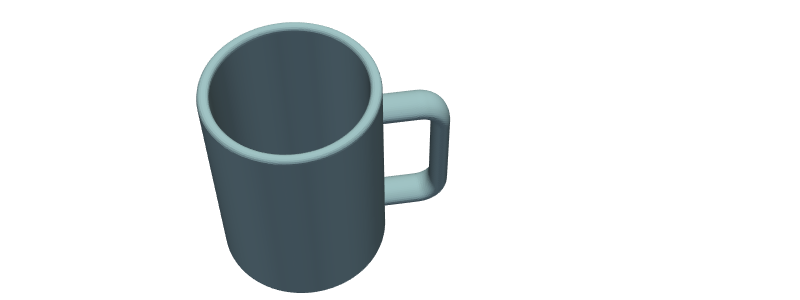

In [5]:
# Visualise the mesh

plotter = pyvista.Plotter(window_size=[800, 300])
vmesh = vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(*vmesh);
plotter.add_mesh(grid, show_edges=False)
plotter.camera.position = (0.0, 0.45, 0.3)
plotter.camera.focal_point = (0.045, 0.05, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(2.0)
plotter.show()

## Time-stepping

In order to time-step, we can approximate:
$$ {\partial T\over \partial t} = \kappa \nabla^2 T $$ by discretising in time and using

$$ {T^{n+1} - T^n\over \delta t} = \kappa \nabla^2 T^{n + 1} $$

where $n$ represents the time-step index.

This is called "backwards Euler". There are more accurate schemes, but this one is simple and stable. With some rearranging, the system of equations becomes:

$$ -\gamma \nabla^2 T^{n+1} + T^{n+1} = T^n $$

In other words, if we know $T^n$, we can solve a linear system to find $T^{n+1}$.



## Physical parameters

* The thermal diffusivity, $\kappa = {k\over \rho C_p}$ is the thermal conductivity $k$, divided by the density and heat capacity.
* The volume of water in the mug is just $V = \pi r^2 h$ and we can then work out the heat capacity of the water.

In [6]:
# Work out some values for the problem
k_mug = 1.0 # W/m/K conductivity
Cp_mug = 920 # J/kg/K heat capacity
rho_mug = 2000 # km/m^3 density
kappa = k_mug/(rho_mug*Cp_mug)
print(f"kappa={kappa} m²/s")

# internal dimensions of "water" part
r = 0.065/2.0 # internal radius of mug
h = 0.095 # fill height of water
vol = np.pi * r**2 * h
print(f"volume={vol * 1e6:.2f} cm³")
Cp_water = 4200 # J/kg/K
rho_water = 1000 # kg/m^3
thermal_mass_water = rho_water * Cp_water * vol
print(f"thermal mass={thermal_mass_water:.2f} J/K")
print(f"A heat flow of 1kW will result in a temperature change of {1000/thermal_mass_water:.2f}°C/s")

kappa=5.434782608695652e-07 m²/s
volume=315.24 cm³
thermal mass=1324.00 J/K
A heat flow of 1kW will result in a temperature change of 0.76°C/s


## Define the finite-element problem

$$ -\gamma \nabla^2 T^{n+1} + T^{n+1} = T^n $$

becomes

$$\int \gamma \nabla u . \nabla v + uv d\Omega = \int u_0 v d\Omega $$

using $u$ for $T^{n+1}$ and $u_0$ for $T^n$.

In [7]:
# Define heat problem

# Linear functionspace of scalars
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)

# Use this function to store values from the previous time-step (Tn)
u0 = Function(V)

# Time-step of 30s.
dt = 30.0
gamma = Constant(mesh, kappa*dt)

a = form((gamma * inner(grad(u), grad(v)) + inner(u, v)) * dx)
L = form(inner(u0, v) * dx)

## Computing the surface heat-flux

We can also create a finite-element form to compute the surface heat flux. This uses a special `ufl` term `FacetNormal` which provides the normal vector to the mesh at the surface.
The heat flux is

$$k \nabla T.n$$

and we only want to compute it on certain surfaces (here labelled with the tags "2" and "3" in the mesh file.

In [8]:
# Compute total heat flux from water in Watts
n = FacetNormal(mesh)
ds = Measure("ds", subdomain_data=facet_tags)
heat_flux = form(k_mug * inner(grad(u0), n) * (ds(3) + ds(2)))

## Applying BCs

We apply boundary conditions on certain facets, labelled "4" (base) and "2" and "3" (interior, in contact with the water), setting the base temperature `T_base` at 15 degrees, and the water to 100.

In [9]:


# Get lists of facets from mesh data to apply BCs
mesh.topology.create_connectivity(2, 3) # topological connectivity f->c
facets = [facet_tags.find(j) for j in range(5)]

# Fix base (label=4) temperature to 15.0
T_base = Constant(mesh, 15.0)
bc0 = dirichletbc(T_base, locate_dofs_topological(V, entity_dim=2,
                                                entities=facets[4]), V=V)

# Fix temperature on internal facets (label=2 and 3) to T_water
T_water = Constant(mesh, 100.0)
bc1 = dirichletbc(T_water,
                  locate_dofs_topological(V,
                                          entity_dim=2,
                                          entities=np.concatenate((facets[2],
                                                                   facets[3]))),
                                          V=V)


## Setting up the solver

In this problem, the left-hand side (A) does not change with time, so we can assemble it into a matrix. PETSc provides an efficient solver.

In [10]:

A = assemble_matrix(a, bcs=[bc0, bc1])
A.assemble()

# Setup the solver
ksp = PETSc.KSP().create(mesh.comm)
ksp.setOperators(A)
ksp.setType("preonly")
ksp.getPC().setType("lu")


## Time loop

Here, we will solve the problem in a loop, each time updating the temperature field `u0`. We have to re-assemble the right-hand side (`b`) at each time step, as `u0` changes.

Some statistics are printed on each time-step, and the output is dumped to file every 4 time-steps.

This may take several minutes to complete.

In [11]:
# Set the initial temperature to 15 degrees
u0.x.array[:] = 15.0

# Solve time-dependent problem
T_water.value = 100.0

out = XDMFFile(MPI.COMM_WORLD, "T.xdmf", "w")
out.write_mesh(mesh)

for j in range(80):
  b = assemble_vector(L)
  apply_lifting(b, [a], bcs=[[bc0, bc1]])
  bc0.set(b.array)
  bc1.set(b.array)

  ksp.solve(b, u0.x.petsc_vec)
  hf = assemble_scalar(heat_flux)

  print('time=', (j + 1)*dt, 'flux=', hf, 'Tmax=', u0.x.array.max(), 'Tmin=', u0.x.array.min())

  if j%4 == 0:
    out.write_function(u0, j)

out.close()

time= 30.0 flux= 376.9063262007775 Tmax= 100.0 Tmin= 15.0
time= 60.0 flux= 169.16890981011446 Tmax= 100.0 Tmin= 15.0
time= 90.0 flux= 105.47111647979612 Tmax= 100.0 Tmin= 15.0
time= 120.0 flux= 81.39911572899678 Tmax= 100.0 Tmin= 15.0
time= 150.0 flux= 71.93397614728417 Tmax= 100.0 Tmin= 15.0
time= 180.0 flux= 68.1515739289491 Tmax= 100.0 Tmin= 15.0
time= 210.0 flux= 66.61124606394281 Tmax= 100.0 Tmin= 15.0
time= 240.0 flux= 65.9631342239299 Tmax= 100.0 Tmin= 15.0
time= 270.0 flux= 65.67408920421734 Tmax= 100.0 Tmin= 15.0
time= 300.0 flux= 65.53230668155858 Tmax= 100.0 Tmin= 15.0
time= 330.0 flux= 65.45294995013793 Tmax= 100.0 Tmin= 15.0
time= 360.0 flux= 65.40157786408098 Tmax= 100.0 Tmin= 15.0
time= 390.0 flux= 65.36388510340794 Tmax= 100.0 Tmin= 15.0
time= 420.0 flux= 65.33369756334842 Tmax= 100.0 Tmin= 15.0
time= 450.0 flux= 65.30818266927787 Tmax= 100.0 Tmin= 15.0
time= 480.0 flux= 65.28592119945226 Tmax= 100.0 Tmin= 15.0
time= 510.0 flux= 65.26611981489422 Tmax= 100.0 Tmin= 15.0


## Visualisation

We can look at the final temperature field with pyvista, but it is much more convenient to download the full output, and view it with ParaView. Click the folder icon on the left, and download `T.h5` and `T.xdmf`. Open `T.xdmf` with ParaView on your own machine.

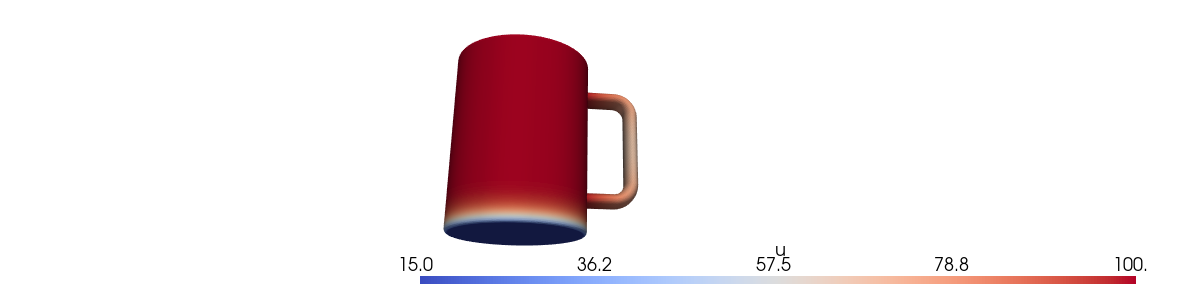

In [12]:
plotter = pyvista.Plotter(window_size=[1200, 300])
grid.point_data["u"] = u0.x.array[:]
grid.set_active_scalars("u")
plotter.add_mesh(grid, show_edges=False, cmap='coolwarm')

plotter.camera.position = (0.0, -0.05, 0.3)
plotter.camera.focal_point = (0.045, 0.05, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(1.0)
plotter.show()

## Task

At the moment, the water temperature is fixed. Instead, let it cool down, depending on the temperature flux `hf`. Plot the water temperature as a function of time.


In [49]:
# Hint - in the time-stepping loop, add the line:
#  T_water.value -= (hf / thermal_mass_water) * dt
# Use matplotlib to plot the temperature
